### Import packages

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [9]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lijnen.csv", sep=";")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(x.replace(',','.'))) 
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(x.replace(',','.'))) 

In [4]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [5]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

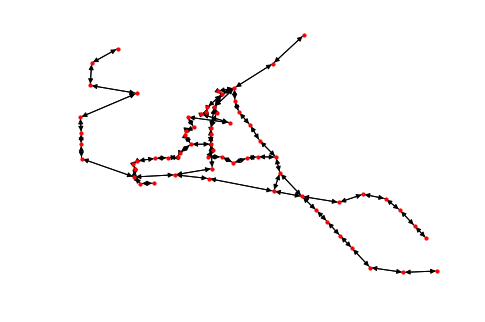

In [6]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

### Route calculation and choice functions

In [7]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["waiting"] = int(random.random() * 10)
    route_info["duration"] += (route_info["transfers"] * 3)
    
    return route_info

In [8]:
def choice(routes, classname):
    if classname == 0:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["waiting"] < routes[index][0]["waiting"]:
                    index = i

    elif classname == 1:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create moving parts

In [76]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        routes.append(((route_calculation(path, FG)), path))

    # Travel direction and route information
    route_info, route = choice(routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [77]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

### Spawn vehicles

In [78]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        vehicle = generate_vehicle(lines[name][x], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(frequency * 60)

### Spawn passengers based on data

In [12]:
origin = pd.read_csv("Data/origin.csv")
destination = pd.read_csv("Data/destination.csv")
origin

,Unnamed: 0,hour,stop,min,median,sum,max,mean
0,0,00:00 - 00:59,Amsteldijk,25,25.0,25,25,0.735294
1,1,00:00 - 00:59,Amstelstation,11,40.5,1561,65,45.911765
2,2,00:00 - 00:59,Amstelveenseweg,11,12.0,56,21,1.647059
3,3,00:00 - 00:59,Bullewijk,10,13.0,149,26,4.382353
4,4,00:00 - 00:59,Burg.de Vlugtlaan,10,12.5,48,13,1.411765
5,5,00:00 - 00:59,Centraal Station,10,79.5,23682,972,696.529412
6,6,00:00 - 00:59,Dam,10,69.0,7393,304,217.441176
7,7,00:00 - 00:59,De Pijp,10,37.0,1645,115,48.382353
8,8,00:00 - 00:59,Europaplein,10,13.0,308,44,9.058824
9,9,00:00 - 00:59,Gaasperplas,15,15.0,15,15,0.441176


In [79]:
def passengers(env, classname):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, classname, env)
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                            env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)

        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 60)

### Run simulation

In [82]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []

# Start the simulation
# env.process(vehicle(env, 0, 10, "metro50", 0))
# env.process(vehicle(env, 0, 10, "metro50", 1))
# env.process(vehicle(env, 0, 10, "metro51", 0))
# env.process(vehicle(env, 0, 10, "metro51", 1))
# env.process(vehicle(env, 0, 10, "metro52", 0))
# env.process(vehicle(env, 0, 10, "metro52", 1))
# env.process(vehicle(env, 0, 10, "metro53", 0))
# env.process(vehicle(env, 0, 10, "metro53", 1))
# env.process(vehicle(env, 0, 10, "metro54", 0))
# env.process(vehicle(env, 0, 10, "metro54", 1))
# env.process(vehicle(env, 0, 10, "tram12", 0))
# env.process(vehicle(env, 0, 10, "tram12", 1))
# env.process(vehicle(env, 0, 10, "tram24", 0))
# env.process(vehicle(env, 0, 10, "tram24", 1))

env.process(passengers(env, 0))
env.run(until = env.now + 1 * 24 * 60 * 60)

### Check results

In [83]:
pd.DataFrame.from_dict(env.vehicles[4].log)

,Message,Timestamp,Value,Geometry
0,Driving from node Noord to node Noorderpark start,2019-01-01 00:00:00,0,POINT (52.40117202 4.93123182)
1,Driving from node Noord to node Noorderpark stop,2019-01-01 00:02:00,0,POINT (52.38855518 4.91789115)
2,Unloading start,2019-01-01 00:02:00,0,POINT (52.38855518 4.91789115)
3,Unloading stop,2019-01-01 00:02:00,30,POINT (52.38855518 4.91789115)
4,Driving from node Noorderpark to node Centraal...,2019-01-01 00:02:30,0,POINT (52.38855518 4.91789115)
5,Driving from node Noorderpark to node Centraal...,2019-01-01 00:04:30,0,POINT (52.37771998 4.90104337)
6,Unloading start,2019-01-01 00:04:30,0,POINT (52.37771998 4.90104337)
7,Unloading stop,2019-01-01 00:04:30,30,POINT (52.37771998 4.90104337)
8,Driving from node CentraalStation to node Roki...,2019-01-01 00:05:00,0,POINT (52.37771998 4.90104337)
9,Driving from node CentraalStation to node Roki...,2019-01-01 00:07:00,0,POINT (52.36928023 4.89229651)


In [15]:
pd.DataFrame.from_dict(env.passengers[5].log)

,Message,Timestamp,Value,Geometry
0,Waiting for tram24,2019-01-01 05:33:15.635078,0,POINT (52.34528169 4.8587373)
1,Waiting for tram24 stop,2019-01-01 06:09:30.000000,0,POINT (52.34528169 4.8587373)
2,In tram24 start,2019-01-01 06:09:30.000000,0,POINT (52.34528169 4.8587373)
3,In tram24 stop,2019-01-01 06:30:30.000000,0,POINT (52.36646202 4.89323826)


In [17]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
        passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route, 
                                        "origin": env.passengers[i].route[0], 
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'], 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id, 
                                        "waiting_time": 0}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("Results/passengers.csv", index=True)

In [18]:
passengerdf

,arrival,class_id,creation,date,departure,destination,lines,origin,route,transfers,transferstations,waiting_time
9535be68-7b9b-11e9-88d4-7831c1d08f6a,06:23:00,0,05:30:00,2019-01-01,06:16:00,DePijp,[tram24],Beethovenstraat,"[Beethovenstraat, GerritvdVeenstraat, RoelofHa...",0,[],0
9535d8be-7b9b-11e9-b11f-7831c1d08f6a,06:05:30,0,05:30:43,2019-01-01,06:03:30,Zuid,"[tram24, metro52]",Dam,"[Dam, Rokin, Vijzelgracht, DePijp, Europaplein...",1,[Rokin],0
9535ea86-7b9b-11e9-b163-7831c1d08f6a,06:31:30,0,05:31:11,2019-01-01,06:12:30,IJsbaanpad,[tram24],MarieHeinekenplein,"[MarieHeinekenplein, DePijp, RoelofHartplein, ...",0,[],0
95360a00-7b9b-11e9-bf36-7831c1d08f6a,05:42:00,0,05:32:01,2019-01-01,05:35:00,Olympiaweg,"[metro52, tram24]",CentraalStation,"[CentraalStation, Rokin, Vijzelgracht, DePijp,...",1,[DePijp],0
953673a8-7b9b-11e9-b61c-7831c1d08f6a,06:23:30,0,05:32:32,2019-01-01,06:12:30,Minervaplein,[tram24],MarieHeinekenplein,"[MarieHeinekenplein, DePijp, RoelofHartplein, ...",0,[],0
95368426-7b9b-11e9-bb28-7831c1d08f6a,06:30:30,0,05:33:15,2019-01-01,06:09:30,Muntplein,[tram24],Olympiaweg,"[Olympiaweg, Olympiaplein, Minervaplein, Beeth...",0,[],0
95368fe8-7b9b-11e9-90da-7831c1d08f6a,06:23:30,0,05:33:19,2019-01-01,06:21:00,Minervaplein,[tram24],GerritvdVeenstraat,"[GerritvdVeenstraat, Beethovenstraat, Minervap...",0,[],0
95369bfa-7b9b-11e9-ad8a-7831c1d08f6a,06:23:00,0,05:33:20,2019-01-01,06:09:30,Europaplein,"[tram24, metro52]",Olympiaweg,"[Olympiaweg, Olympiaplein, Minervaplein, Beeth...",1,[DePijp],0
9536a7a8-7b9b-11e9-af99-7831c1d08f6a,05:53:06,0,05:34:03,2019-01-01,05:43:36,Noord,[metro52],Vijzelgracht,"[Vijzelgracht, Rokin, CentraalStation, Noorder...",0,[],0
9536d1a6-7b9b-11e9-8dc9-7831c1d08f6a,06:23:00,0,05:34:36,2019-01-01,06:06:30,Europaplein,"[tram24, metro52]",IJsbaanpad,"[IJsbaanpad, OlympischStadion, Olympiaweg, Oly...",1,[DePijp],0


In [19]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("Results/vehicles.csv", index=True)

In [20]:
vehicledf

,arrival,date,departure,line,route
9535a97a-7b9b-11e9-8606-7831c1d08f6a,05:48:00,2019-01-01,05:30:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
9536eaa6-7b9b-11e9-a686-7831c1d08f6a,05:53:06,2019-01-01,05:35:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
95376258-7b9b-11e9-98ce-7831c1d08f6a,05:54:00,2019-01-01,05:36:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
9538c48c-7b9b-11e9-8da9-7831c1d08f6a,05:59:06,2019-01-01,05:41:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
9538e5b8-7b9b-11e9-bd36-7831c1d08f6a,06:00:00,2019-01-01,05:42:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
953a5722-7b9b-11e9-9135-7831c1d08f6a,06:05:06,2019-01-01,05:47:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
953a8238-7b9b-11e9-be79-7831c1d08f6a,06:06:00,2019-01-01,05:48:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
953b52e4-7b9b-11e9-8aa2-7831c1d08f6a,06:11:06,2019-01-01,05:53:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
953b7436-7b9b-11e9-9bbd-7831c1d08f6a,06:12:00,2019-01-01,05:54:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
953c8326-7b9b-11e9-9ee0-7831c1d08f6a,06:17:06,2019-01-01,05:59:06,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
